[nltk_data] Downloading package punkt to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/parthbatwara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Number of words removed (appearing in ≥80% of summaries): 23
Silhouette Score: 0.303


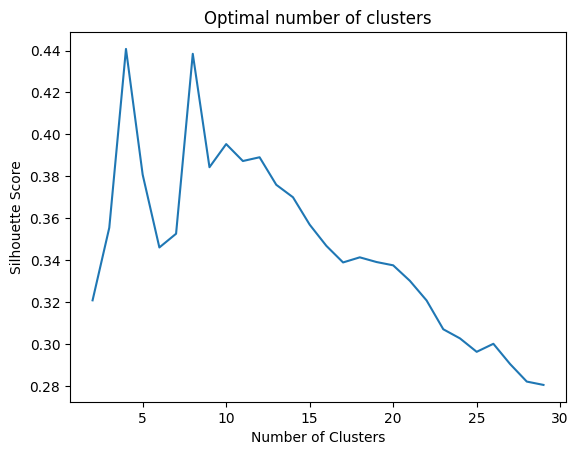

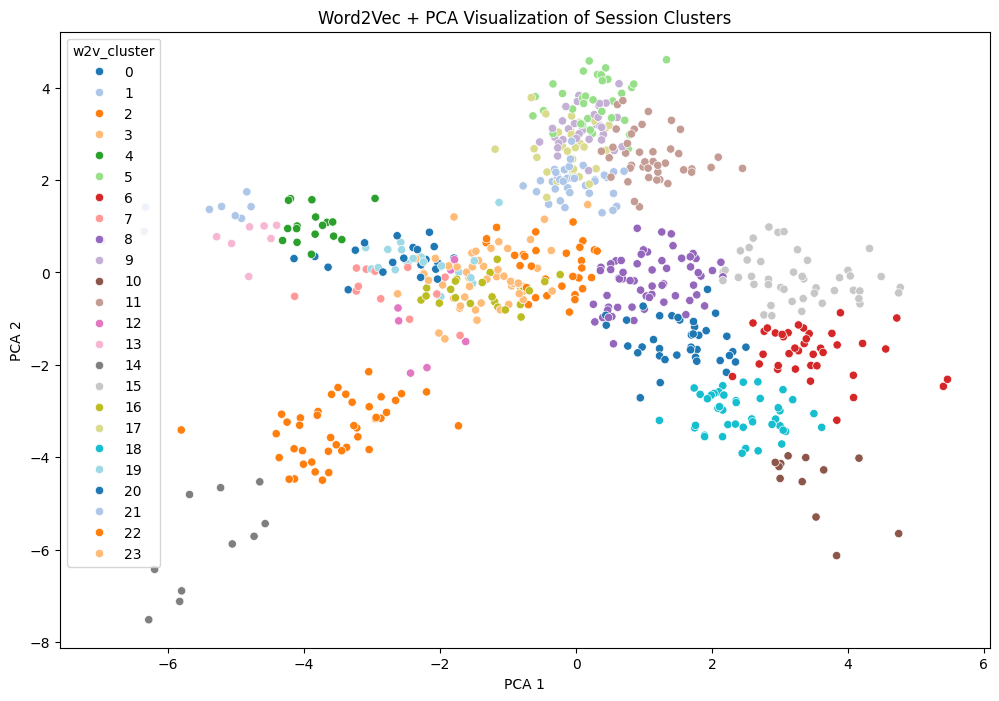


Cluster 0 (39 summaries):
[  7  10  30  43  62 102 134 162 207 251 267 275 302 306 316 321 334 342
 379 390 398 405 419 422 458 477 486 500 501 519 527 550 569 581 600 604
 615 623 629]

Cluster 1 (36 summaries):
[  5  16  27  28  75  88  90 111 116 132 133 178 200 206 293 345 350 358
 371 393 397 424 425 427 432 451 473 502 514 539 605 614 617 625 652 656]

Cluster 2 (42 summaries):
[ 34  37  46  84  91 115 154 165 172 187 191 242 254 278 288 299 335 346
 357 364 373 385 403 404 420 446 452 454 459 460 462 479 481 488 510 554
 591 595 610 620 621 660]

Cluster 3 (17 summaries):
[ 19 110 121 131 145 257 269 284 406 416 439 464 564 594 597 601 631]

Cluster 4 (17 summaries):
[ 52 146 151 181 221 231 245 255 258 274 296 326 338 552 573 596 598]

Cluster 5 (38 summaries):
[ 11  99 100 158 174 208 209 227 237 239 256 270 279 298 303 355 375 383
 399 401 421 449 474 484 491 512 535 547 557 562 575 580 592 611 616 640
 641 662]

Cluster 6 (38 summaries):
[ 13  23  44  47  51  78 153 156 166

/var/folders/q1/r9lsqt2n4dz2fbpxq3wwh7m80000gn/T/ipykernel_17663/2556590586.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')


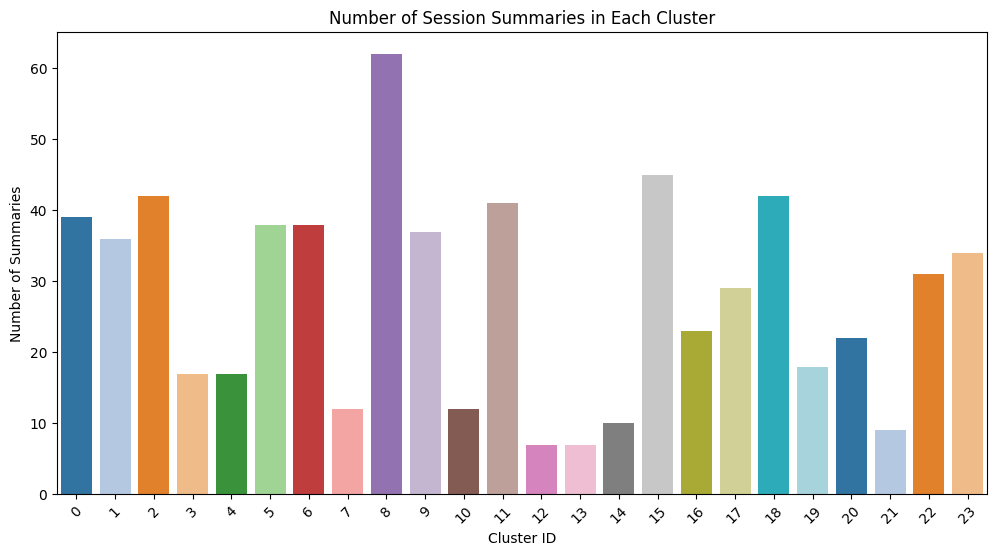


Summaries in Cluster 0 (Total: 39) — Sorted by Similarity:
Serial No: 251.0, Similarity: 0.9982
Serial No: 30.0, Similarity: 0.9971
Serial No: 379.0, Similarity: 0.9963
Serial No: 342.0, Similarity: 0.9962
Serial No: 7.0, Similarity: 0.9958
Serial No: 302.0, Similarity: 0.9954
Serial No: 486.0, Similarity: 0.9954
Serial No: 581.0, Similarity: 0.9950
Serial No: 600.0, Similarity: 0.9950
Serial No: 419.0, Similarity: 0.9942
Serial No: 405.0, Similarity: 0.9930
Serial No: 267.0, Similarity: 0.9930
Serial No: 10.0, Similarity: 0.9926
Serial No: 519.0, Similarity: 0.9923
Serial No: 500.0, Similarity: 0.9915
Serial No: 477.0, Similarity: 0.9914
Serial No: 550.0, Similarity: 0.9911
Serial No: 390.0, Similarity: 0.9910
Serial No: 43.0, Similarity: 0.9907
Serial No: 615.0, Similarity: 0.9906
Serial No: 458.0, Similarity: 0.9890
Serial No: 422.0, Similarity: 0.9890
Serial No: 604.0, Similarity: 0.9869
Serial No: 527.0, Similarity: 0.9867
Serial No: 398.0, Similarity: 0.9862
Serial No: 569.0, Si

In [27]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics import silhouette_score
from collections import defaultdict
from collections import Counter
import joblib

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

NUM_OF_CLUSTERS = 24

# ------------------------
# 1. Load Data
# ------------------------
df = pd.read_excel("../Session-Summary-for-E6-project.xlsx")
df = df.dropna(subset=['Session_Summary'])

# ------------------------
# 2. Preprocessing
# ------------------------
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return tokens

df['tokens'] = df['Session_Summary'].apply(clean_text)

# ------------------------
# 3. Remove high-frequency words (appearing in >=80% of summaries)
# ------------------------
# Count in how many summaries each word appears
summary_counts = Counter()

for tokens in df['tokens']:
    unique_tokens = set(tokens)
    summary_counts.update(unique_tokens)

# Threshold: words appearing in >=80% of summaries
threshold = 0.3 * len(df)
common_words = set([word for word, count in summary_counts.items() if count >= threshold])

print(f"\nNumber of words removed (appearing in ≥80% of summaries): {len(common_words)}")

# Remove those words from tokens
df['filtered_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in common_words])

# ------------------------
# 4. Train Word2Vec Model (CBOW)
# ------------------------
w2v_model = Word2Vec(sentences=df['filtered_tokens'], vector_size=300, window=300, min_count=2, sg=0, workers=4, seed=42)

# ------------------------
# 5. Average Word Vectors for Each Summary
# ------------------------
def get_avg_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['vector'] = df['filtered_tokens'].apply(lambda x: get_avg_vector(x, w2v_model))
X_w2v = np.vstack(df['vector'].values)

# ------------------------
# 6. KMeans Clustering (25 sessions)
# ------------------------
kmeans = KMeans(n_clusters=NUM_OF_CLUSTERS, random_state=42)
df['w2v_cluster'] = kmeans.fit_predict(X_w2v)

# Silhouette Score
sil_score = silhouette_score(X_w2v, df['w2v_cluster'])
print(f"Silhouette Score: {sil_score:.3f}")

# Silhouette scores for various K
scores = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_w2v)
    score = silhouette_score(X_w2v, labels)
    scores.append(score)

plt.plot(range(2, 30), scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal number of clusters")
plt.show()

# ------------------------
# 7. Visualize using PCA
# ------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_w2v)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['w2v_cluster'], palette='tab20', legend='full')
plt.title("Word2Vec + PCA Visualization of Session Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# ------------------------
# 8. Group Serial Numbers by Cluster
# ------------------------
cluster_groups = defaultdict(list)

for idx, row in df.iterrows():
    cluster_id = row['w2v_cluster']
    serial_no = row['SerialNo']
    cluster_groups[cluster_id].append(serial_no)

# Convert to list of arrays
session_clusters = [np.array(cluster_groups[i]) for i in range(NUM_OF_CLUSTERS)]

# Display grouped arrays
for i, cluster in enumerate(session_clusters):
    print(f"\nCluster {i} ({len(cluster)} summaries):")
    print(cluster)

# ------------------------
# 9. Plot frequency of sessions in each cluster
# ------------------------
cluster_counts = df['w2v_cluster'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='tab20')
plt.title("Number of Session Summaries in Each Cluster")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Summaries")
plt.xticks(rotation=45)
plt.show()

# ------------------------
# 10. Compute Global Word2Vec Vector for Each Cluster
# ------------------------

# Compute average vector for each cluster
global_cluster_vectors = {
    cluster_id: np.mean(X_w2v[df['w2v_cluster'] == cluster_id], axis=0)
    for cluster_id in range(NUM_OF_CLUSTERS)
}

# Dictionary to hold global vectors for each cluster
from scipy.spatial.distance import cosine

# Dictionary to store ordered summaries by similarity for each cluster
ordered_summaries_by_similarity = {}

for cluster_id in range(NUM_OF_CLUSTERS):
    # Get global vector for the cluster
    global_vector = global_cluster_vectors[cluster_id]
    
    # Get all summaries in this cluster
    cluster_df = df[df['w2v_cluster'] == cluster_id][['SerialNo', 'vector']]
    
    # Compute cosine similarity between each summary's vector and the global vector
    cluster_df['similarity'] = cluster_df['vector'].apply(lambda vec: 1 - cosine(vec, global_vector) if np.linalg.norm(vec) != 0 and np.linalg.norm(global_vector) != 0 else 0)
    
    # Sort by decreasing similarity
    cluster_df = cluster_df.sort_values(by='similarity', ascending=False)
    
    # Store ordered SerialNos and similarity for this cluster
    ordered_summaries_by_similarity[cluster_id] = cluster_df[['SerialNo', 'similarity']].values.tolist()
    
    # Print all summaries for this cluster
    print(f"\nSummaries in Cluster {cluster_id} (Total: {len(cluster_df)}) — Sorted by Similarity:")
    for serial, sim in ordered_summaries_by_similarity[cluster_id]:
        print(f"Serial No: {serial}, Similarity: {sim:.4f}")


In [28]:
from scipy.spatial.distance import cosine

# Cluster to work with
target_cluster_id = 0

# Get summaries in Cluster 0
cluster_df = df[df['w2v_cluster'] == target_cluster_id][['SerialNo', 'filtered_tokens', 'vector']]

for idx, row in cluster_df.iterrows():
    serial_no = row['SerialNo']
    tokens = row['filtered_tokens']
    summary_vector = row['vector']
    
    word_similarities = []
    
    # Use set(tokens) to avoid duplicate words
    for word in set(tokens):
        if word in w2v_model.wv:
            word_vector = w2v_model.wv[word]
            similarity = 1 - cosine(word_vector, summary_vector) if np.linalg.norm(word_vector) != 0 and np.linalg.norm(summary_vector) != 0 else 0
            word_similarities.append((word, similarity))
    
    # Sort words by decreasing similarity
    word_similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Print results for this summary
    print(f"\nSummary Serial No: {serial_no} — Top words by similarity to its own averaged vector:")
    for word, sim in word_similarities:
        print(f"{word}: {sim:.4f}")



Summary Serial No: 7 — Top words by similarity to its own averaged vector:
size: 0.9912
learned: 0.9742
say: 0.9646
small: 0.9170
whole: 0.9134
limit: 0.9132
thing: 0.9099
parameter: 0.9099
pdf: 0.9057
theorem: 0.8884
measure: 0.8821
statistical: 0.8796
confidence: 0.8761
central: 0.8739
assuming: 0.8734
population: 0.8722
company: 0.8625
interval: 0.8524
term: 0.8501
estimate: 0.8395
less: 0.8318
calculate: 0.8225
make: 0.8198
plotted: 0.8185
manager: 0.8035
extra: 0.8032
key: 0.7991
explained: 0.7700
hour: 0.7609
represented: 0.7579
u: 0.7504
tried: 0.7432
worked: 0.7423
explain: 0.7375
better: 0.7262
introduction: 0.7170
real: 0.7063
test: 0.7041
decision: 0.6915
sir: 0.6914
started: 0.6593
wrapped: 0.6074
observation: 0.5919
important: 0.5807
talking: 0.5518
variance: 0.5439
result: 0.5154
useful: 0.4820
example: 0.4651
touched: 0.4441
two: 0.4001
probability: 0.3724
work: 0.3628
significantly: 0.3183
based: 0.2910
function: 0.2339
help: 0.2054
confidently: 0.1725
density: 0.1674


In [29]:
from collections import defaultdict, Counter
from scipy.spatial.distance import cosine

# Number of clusters
num_clusters = NUM_OF_CLUSTERS
top_k = 20  # Number of top keywords to extract (no longer needed for filtering)

# Store top keywords and detailed scores for each cluster
cluster_keywords = []              # just the word list
cluster_keyword_scores = []        # list of (word, score, avg_cosine, norm_freq)

# Loop through all clusters
for cluster_id in range(num_clusters):
    cluster_df = df[df['w2v_cluster'] == cluster_id][['SerialNo', 'filtered_tokens', 'vector']]
    n_summaries = len(cluster_df)

    word_freq = Counter()
    word_cosine_sum = defaultdict(float)

    for idx, row in cluster_df.iterrows():
        tokens = row['filtered_tokens']
        summary_vector = row['vector']

        for word in set(tokens):
            if word in w2v_model.wv:
                word_vector = w2v_model.wv[word]
                if np.linalg.norm(word_vector) != 0 and np.linalg.norm(summary_vector) != 0:
                    similarity = 1 - cosine(word_vector, summary_vector)
                    word_freq[word] += 1
                    word_cosine_sum[word] += similarity

    word_scores = []
    for word in word_freq:
        avg_cosine = word_cosine_sum[word] / word_freq[word]
        norm_freq = word_freq[word] / n_summaries
        score = avg_cosine * norm_freq
        word_scores.append((word, score, avg_cosine, norm_freq))

    # Identify the maximum score in the cluster
    max_score = max(word_scores, key=lambda x: x[1])[1]

    # Get keywords with scores >= 50% of the maximum score
    filtered_keywords = [word for word in word_scores if word[1] >= 0.5 * max_score]

    cluster_keywords.append([word for word, _, _, _ in filtered_keywords])
    cluster_keyword_scores.append(filtered_keywords)

# Print results with scores
for cluster_id, keyword_data in enumerate(cluster_keyword_scores):
    print(f"\nCluster {cluster_id} — Keywords with score >= 50% of the maximum score:")
    
    for word, score, avg_cosine, norm_freq in keyword_data:
        print(f"{word}: Score = {score:.4f} (Avg Cosine: {avg_cosine:.4f}, Normalized Freq: {norm_freq:.4f})")


Cluster 0 — Keywords with score >= 50% of the maximum score:
interval: Score = 0.6678 (Avg Cosine: 0.8682, Normalized Freq: 0.7692)
population: Score = 0.4026 (Avg Cosine: 0.8724, Normalized Freq: 0.4615)
confidence: Score = 0.6445 (Avg Cosine: 0.8667, Normalized Freq: 0.7436)
parameter: Score = 0.3473 (Avg Cosine: 0.9029, Normalized Freq: 0.3846)
statistically: Score = 0.4064 (Avg Cosine: 0.8342, Normalized Freq: 0.4872)
independent: Score = 0.3621 (Avg Cosine: 0.8306, Normalized Freq: 0.4359)
significant: Score = 0.3443 (Avg Cosine: 0.9590, Normalized Freq: 0.3590)

Cluster 1 — Keywords with score >= 50% of the maximum score:
discussion: Score = 0.2428 (Avg Cosine: 0.7946, Normalized Freq: 0.3056)
pattern: Score = 0.2132 (Avg Cosine: 0.8530, Normalized Freq: 0.2500)
summary: Score = 0.2116 (Avg Cosine: 0.8465, Normalized Freq: 0.2500)
dataset: Score = 0.2638 (Avg Cosine: 0.8634, Normalized Freq: 0.3056)
session: Score = 0.2390 (Avg Cosine: 0.9558, Normalized Freq: 0.2500)
plot: Scor

In [30]:
# Save after building
# joblib.dump(df, "df_with_vectors.pkl")
# joblib.dump(w2v_model, "w2v_model.pkl")
# joblib.dump(global_cluster_vectors, "global_cluster_vectors.pkl")

['global_cluster_vectors.pkl']

/var/folders/q1/r9lsqt2n4dz2fbpxq3wwh7m80000gn/T/ipykernel_17663/795624774.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_ids, y=keyword_counts, palette='tab20')


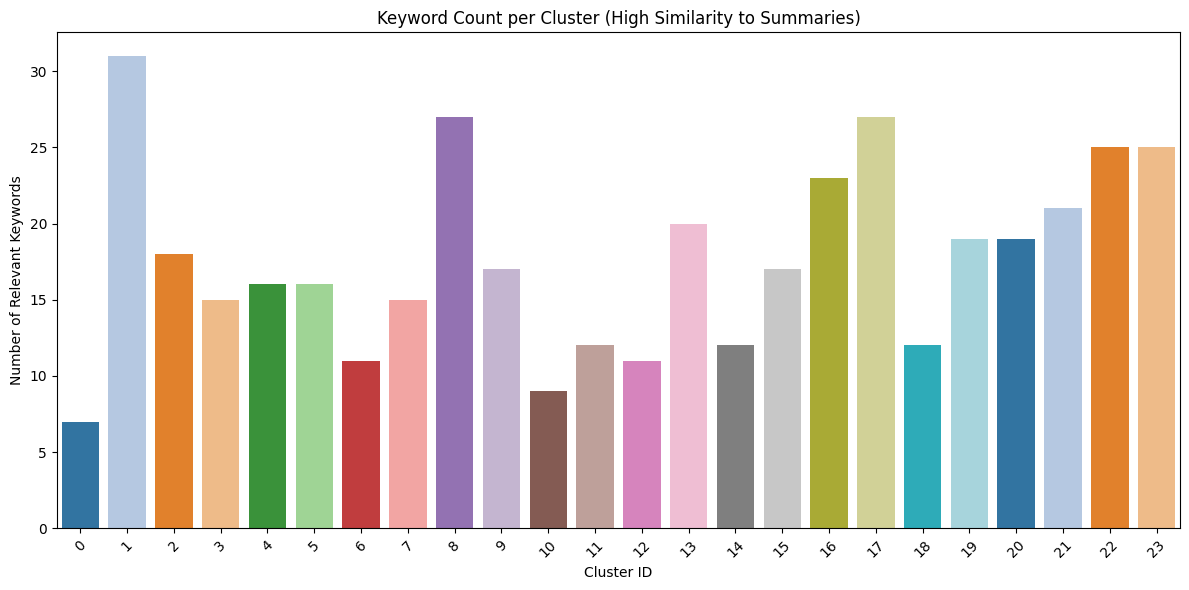

In [31]:
# Prepare data
cluster_ids = list(range(len(cluster_keywords)))
keyword_counts = [len(keywords) for keywords in cluster_keywords]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_ids, y=keyword_counts, palette='tab20')
plt.xlabel("Cluster ID")
plt.ylabel("Number of Relevant Keywords")
plt.title("Keyword Count per Cluster (High Similarity to Summaries)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()